# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
!pip install nltk

     |████████████████████████████████| 1.5MB 961kB/s eta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk


In [39]:
# basic data libraries
import pandas as pd
import numpy as np
import re
from sqlalchemy import create_engine

# scikit-learn modules for pipelining, transformation, model fitting and classification
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report

# nltk-modules for text processing, tokenizing and lemmatizing
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download relevant ntlk packages
nltk.download(["punkt", "stopwords", "wordnet"])

# pickle for python object serialization and storing
import pickle
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# load data from database

engine = create_engine('sqlite:///crisisresponse.db')
df = pd.read_sql_table('messages', engine)
X = df.loc[:,"message"]
Y = df.iloc[:,4:40]

### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    """
    Tokenize, lemmatize, lower and remove punctuation of input text.

    Input arguments:
        text: Single string with input text 
              Example: 'For today:= this is, a advanced _ example #- String!'
              
    Output:
        output: List of processed string
                Example: ['today', 'advanced', 'example', 'string']
        
    """
    # set text to lower case and remove punctuation
    text = re.sub("[\W_]", " ", text)
    text= text.lower()

    # tokenize words 
    tokens = word_tokenize(text)
    
    # lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # init and remove stopwords
    stop_words = set(stopwords.words('english'))
    output = [lemmatizer.lemmatize(w) for w in tokens if not w in stop_words]

    return output

#### Quick check of function tokenize

In [5]:
tokenize("For today:= this is, a advanced _ example #- String!")

['today', 'advanced', 'example', 'string']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [6]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=100)))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

print("""
Shape of all elements: \n\t X_train: {}
\t X_test: {}
\t Y_train: {}
\t Y_test: {}""".format(X_train.shape,
                          X_test.shape,
                          Y_train.shape,
                          Y_test.shape))


Shape of all elements: 
	 X_train: (18219,)
	 X_test: (7809,)
	 Y_train: (18219, 36)
	 Y_test: (7809, 36)


In [8]:
# train pipeline
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip..._score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=None))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

#### Create Functions for testing

In [17]:
def flat_arr_df(two_d_data):
    """
    Flatten array/list of arrays/lists and dataframes to lists.

    Input arguments:
        two_d_data: dataframe or array/list of arrays/lists 
                    Example: [[1,2,3],[4,5,6],[7,8,9]]
              
    Output:
        flat_data: List of flattened Input
                   Example: [1,2,3,4,5,6,7,8,9]
    
    """

    if isinstance(two_d_data, (list, np.ndarray)):
        if isinstance(two_d_data[0], (list, np.ndarray)):
            flat_data = [item for sublist in two_d_data for item in sublist]
        else:
            print("Wrong datatype used, cannot flat this object")
            return ""
    elif isinstance(two_d_data, pd.DataFrame):
            flat_data = list(two_d_data.values.flatten())
    
    return flat_data

def return_multioutput_f1_prec_recall(Y_pred, Y_test, mac_avg=False):
    """
    Output classification report (f1, precision, recall) seperated for every category in
    Multi_Output_Data

    Input arguments:
        Y_pred: dataframe or array/list of arrays/lists 
                    Example: [[1,2,3],[4,5,6],[7,8,9]]
        
        Y_test: dataframe or array/list of arrays/lists 
                    Example: [[1,2,3],[4,5,6],[7,8,9]]
                    
        mac_avg: If True returns Dict with Category names and Macro Average Value only
              
    Output:
        If mac_avg==False: prints precision, recall and f1-score
        If mac_avg==True: returns Dict with Category names and Macro Average Value only
    
    """
    if mac_avg:
        mac_avg_dict = {}
        
    for pred_row, test_row, colname in zip(Y_pred.T, Y_test.to_numpy().T, Y_test.columns):
        if mac_avg:
            mac_avg_dict[colname] = (classification_report(pred_row, test_row, output_dict=True)["macro avg"]["precision"],
                                     classification_report(pred_row, test_row, output_dict=True)["macro avg"]["recall"])
        else:
            print("Report for Category: {}".format(colname))
            print(classification_report(pred_row, test_row))    
    
    if mac_avg:
        return mac_avg_dict
    
def return_flatted_f1_prec_recall(Y_pred, Y_test, mac_avg=False):
    """
    Output classification report (f1, precision, recall) for flatted prediction and test data.

    Input arguments:
        Y_pred: dataframe or array/list of arrays/lists 
                    Example: [[1,2,3],[4,5,6],[7,8,9]]
        
        Y_test: dataframe or array/list of arrays/lists 
                    Example: [[1,2,3],[4,5,6],[7,8,9]]
                    
        mac_avg: If True returns Macro Average Value only
              
    Output:
        If mac_avg==False: prints precision recall and f1-score
        If mac_avg==True: returns Macro Average only
    
    """
    
    flat_Y_pred = flat_arr_df(Y_pred)
    flat_Y_test = flat_arr_df(Y_test)
    if mac_avg:
        return classification_report(flat_Y_pred, flat_Y_test, output_dict=True)["macro avg"]["precision"]
    else:
        print(classification_report(flat_Y_pred, flat_Y_test))

#### Quick check of functions flat_arr_df and display_f1_prec_recall

In [11]:
test_data_arr = [[1,2,3],[4,5,6],[7,8,9]]
test_data_df = pd.DataFrame(test_data_arr)
flat_arr_df(test_data_arr)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [12]:
flat_arr_df(test_data_df)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [13]:
return_flatted_f1_prec_recall(test_data_arr,test_data_df)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



#### Test real model prediction

In [14]:
Y_pred = pipeline.predict(X_test)

#### Evaluate over whole flattened prediction

In [15]:
return_flatted_f1_prec_recall(Y_pred,Y_test)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97    264901
           1       0.54      0.82      0.65     16223

   micro avg       0.95      0.95      0.95    281124
   macro avg       0.76      0.89      0.81    281124
weighted avg       0.96      0.95      0.95    281124



#### Evaluate every Category on it's own

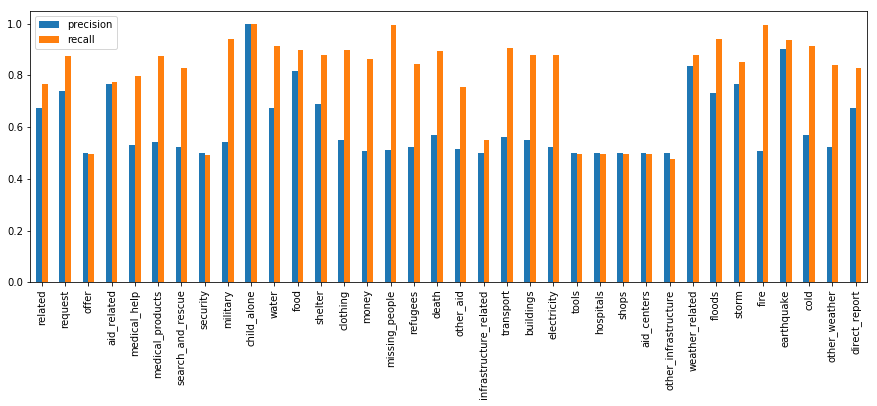

In [32]:
cla_report_rfc_b=pd.DataFrame(return_multioutput_f1_prec_recall(Y_pred, Y_test,mac_avg=True)).T
cla_report_rfc_b.rename(columns={0:"precision_rfb_b",1:"recall_rfb_b"}, inplace=True)
_ = cla_report_rfc_b.plot(kind="bar", figsize=(15,5))

### 6. Improve your model
Use grid search to find better parameters. 

In [33]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__estimator__bootstrap', 'clf__estimator__class_weight', 'clf__estimator__criterion', 'clf__estimator__max_depth', 'clf__estimator__max_features', 'clf__estimator__max_leaf_nodes', 'clf__estimator__min_impurity_decrease', 'clf__estimator__min_impurity_split', 'clf__estimator__min_samples_leaf', 'clf__estimator__min_samples_split', 'clf__estimator__min_weight_fraction_leaf', 'clf__estimator__n_estimators', 'clf__estimator__n_jobs', 'clf__estimator__oob_score', 'clf__estimator__random_state', 'clf__estimator__verbose', 'clf__estimator__

In [49]:
parameters = {
        'clf__estimator__min_samples_split': [2, 3, 4],
        'clf__estimator__n_estimators': [100, 200, 500],
        'clf__estimator__criterion': ['entropy', 'gini']
    }

cv =  GridSearchCV(pipeline, param_grid=parameters, verbose=3, n_jobs=20)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
cv.fit(X_train, Y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


In [ ]:
cv.best_params_

{'clf__estimator__criterion': 'entropy',
 'clf__estimator__min_samples_split': 2}

In [22]:
Y_pred = cv.predict(X_test)

In [31]:
display_f1_prec_recall(Y_pred,Y_test)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    268917
           1       0.46      0.82      0.59     14140
           2       0.45      0.27      0.33        83

   micro avg       0.94      0.94      0.94    283140
   macro avg       0.63      0.68      0.63    283140
weighted avg       0.96      0.94      0.95    283140



In [ ]:
cla_report_rfc_a = pd.DataFrame(return_multioutput_f1_prec_recall(Y_pred, Y_test,mac_avg=True)).T
cla_report_rfc_a.rename(columns={0:"precision_rfc_a",1:"recall_rfc_a"}, inplace=True)
cla_report_rfc_a = cla_report_rfc_a.concat(cla_report_rfc_b, axis=1)
_ = cla_report_mnb.plot(kind="bar", figsize=(15,5))

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

  * https://medium.com/@gabrielziegler3/multiclass-multilabel-classification-with-xgboost-66195e4d9f2d
  * https://github.com/berkurka/Reddit-Classifier/blob/master/Notebooks/03%20Model.ipynb
  * https://gist.github.com/quadrismegistus/92a7fba479fc1e7d2661909d19d4ae7e
  * https://towardsdatascience.com/3-basic-approaches-in-bag-of-words-which-are-better-than-word-embeddings-c2cbc7398016
  * https://www.kaggle.com/diveki/classification-with-nlp-xgboost-and-pipelines
  * https://levelup.gitconnected.com/classifying-reddit-posts-with-natural-language-processing-and-random-forest-classifier-af2d8fa77bd3

#### Adding additional Feature: Message starts/ends with Question term

In [46]:
class MessageIsQuestion(BaseEstimator, TransformerMixin):

    def message_question(self, text):
        # tokenize by sentences
        sentence_list =  nltk.sent_tokenize(text)
        print(sentence_list)
        for sentence in sentence_list:
            # tokenize each sentence into words and tag part of speech
            if "Wh" in sentence:
                return True
            else:
                return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        # apply starting_verb function to all values in X
        X_tagged = pd.Series(X).apply(self.message_question)

        return pd.DataFrame(X_tagged)

In [47]:
pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('message_question', MessageIsQuestion())
        ])),

        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=100))
    )])

In [48]:
miq = MessageIsQuestion()
miq.transform(X_train)

['moral support.', 'the situation is overwhelming for us.', 'we need to find a way to go find our family in the US because we are the only ones left of this ( incomplete )']
['Over 100 tanker lorries from Neyveli Lignite Corporation and Nellikuppam sugar factory besides those of the civic bodies had been pressed into service to provide water.']
['IF I LIVING IN BIZOTONCARREFOUR WHAT CENTER WHO FIND AROUND OF ME, I WOULD EQUIPMENT SUCH AS TO ENCASEFOOD CORPORATION, MEDICAL SUPPLIES, SCOLARY SUPPLIES.']
['Digicel has no signal in Jeremie']
['Now women can be seen walking everywhere unescorted, shopping in the markets and strolling along the streets in their hijabs (head scarves) and flowing robes.']
['Naval commandos have been deployed in some of the worst-hit areas, but authorities were yet to carry out airdrops of food and other relief materials in areas where people were marooned by the swollen waters.']
['All the trees and lamp posts have fallen.']
['I see bad news.', 'We are under t

,message
784,False
21680,False
7009,False
458,False
20656,False
23022,False
19849,False
2950,False
9037,False
7957,False


#### Using Multinominal Naive Bayes

In [42]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html?highlight=nlp

from sklearn.naive_bayes import MultinomialNB

In [43]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(MultinomialNB()))
    ])

In [47]:
_ = pipeline.fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/naive_bayes.py:465: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


In [45]:
Y_pred = pipeline.predict(X_test)

In [46]:
display_f1_prec_recall(Y_pred, Y_test)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97    270879
           1       0.38      0.78      0.51     12261
           2       0.00      0.00      0.00         0

   micro avg       0.94      0.94      0.94    283140
   macro avg       0.46      0.57      0.49    283140
weighted avg       0.96      0.94      0.95    283140



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Compare RandomForest and Multinominal Naive Bayes

In [ ]:
cla_report_mnb=pd.DataFrame(return_multioutput_f1_prec_recall(Y_pred, Y_test,mac_avg=True)).T
cla_report_mnb.rename(columns={0:"precision_mnb",1:"recall_mnb"}, inplace=True)
cla_report_mnb = cla_report_mnb.concat(cla_report_rfc_a, axis=1)
_ = cla_report_mnb.plot(kind="bar", figsize=(15,5))

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.